<a href="https://colab.research.google.com/github/donikurtz/HourlyEnergyConsumption/blob/main/01_analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/PROJETOS/Hourly Energy Consumption/bases/

/content/drive/MyDrive/PROJETOS/Hourly Energy Consumption/bases


In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

In [89]:
file_path = 'AEP_hourly.csv'

In [90]:
df = pd.read_csv(file_path)

In [91]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [92]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [93]:
df.set_index('Datetime', inplace=True)

In [94]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [95]:
df_m = df.resample('M').sum()

In [96]:
df_m.head()

,AEP_MW
Datetime,
2004-10-31,10349073.0
2004-11-30,10677917.0
2004-12-31,12452864.0
2005-01-31,12735114.0
2005-02-28,11085745.0


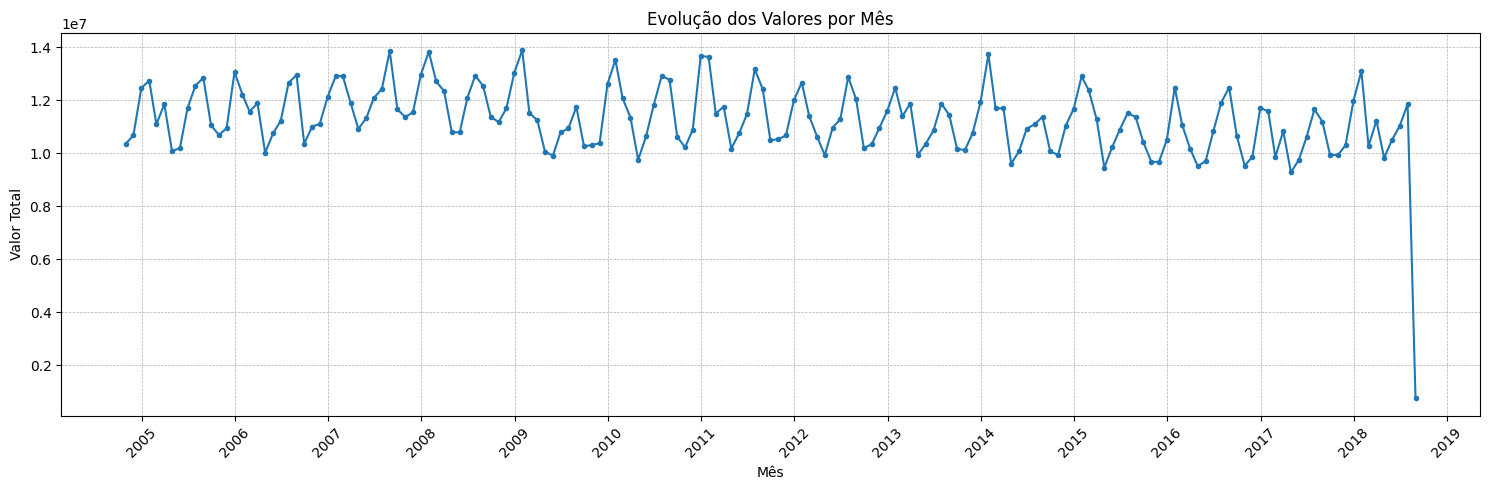

In [99]:
plt.figure(figsize=(15, 5))
plt.plot(df_m.index, df_m['AEP_MW'], marker='.', linestyle='-')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Evolução dos Valores por Mês')
plt.xlabel('Mês')
plt.ylabel('Valor Total')
plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

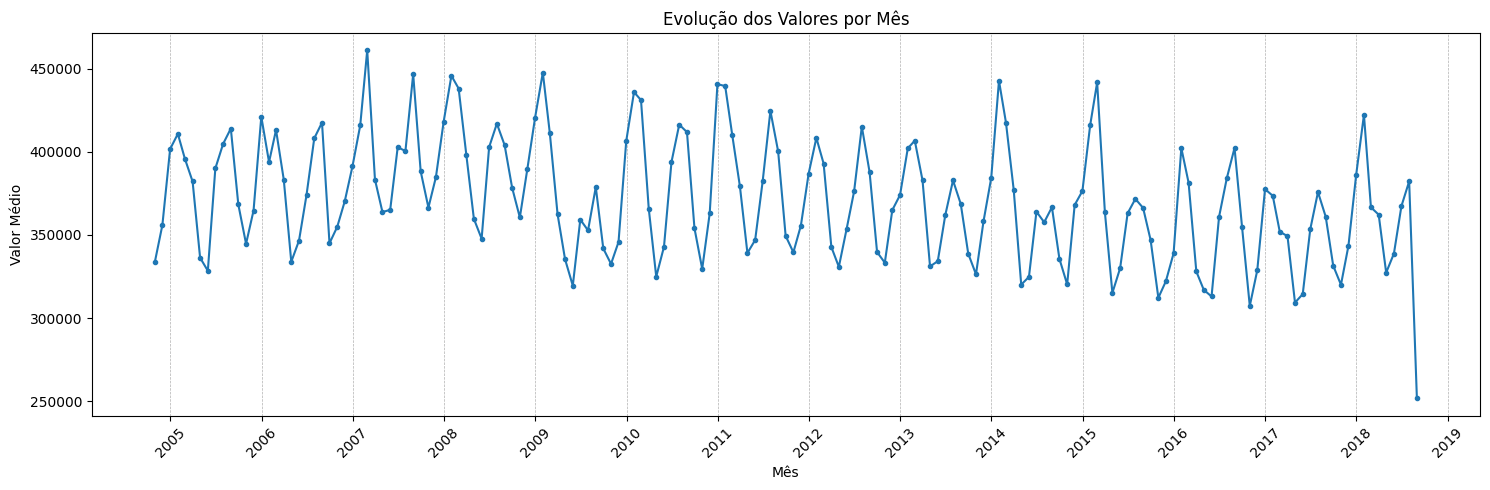

In [98]:
df_m2 = df.resample('D').sum().resample('M').mean()

plt.figure(figsize=(15, 5))
plt.plot(df_m2.index, df_m2['AEP_MW'], marker='.', linestyle='-')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Evolução dos Valores por Mês')
plt.xlabel('Mês')
plt.ylabel('Valor Médio')
plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
plt.grid(False, which='major', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [117]:

# Função para plotar os dados de um intervalo de anos
def plot_dados_ano(df, ano_inicio, ano_fim):
    plt.figure(figsize=(15, 5))

    # Cria uma paleta de cores para diferenciar cada ano
    cores = plt.cm.viridis(np.linspace(0, 1, ano_fim - ano_inicio + 1))

    for i, ano in enumerate(range(ano_inicio, ano_fim + 1)):
        # Filtrando os dados para o ano atual no loop
        df_ano = df[(df.index > f'{ano-1}-12-31') & (df.index < f'{ano+1}-01-01')]

        # Garantindo que os dados estão alinhados por mês
        df_ano.index = df_ano.index.map(lambda d: d.replace(year=2000))

        # Plotando os dados do ano atual
        plt.plot(df_ano.index, df_ano['AEP_MW'], marker='.', linestyle='-', label=str(ano), color=cores[i])

    # Configurações do eixo x
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    # Configurações do eixo y
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-6:.1f}M'))

    # Título e rótulos
    plt.title(f'Evolução dos Valores de AEP_MW por Mês de {ano_inicio} a {ano_fim}')
    plt.xlabel('Mês')
    plt.ylabel('Valor Total (em milhões)')

    # Legenda
    plt.legend()

    # Grade
    plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
    plt.grid(False, which='major', axis='y')

    # Limites do eixo x
    plt.xlim([pd.Timestamp('2000-01-01'), pd.Timestamp('2000-12-31')])

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()




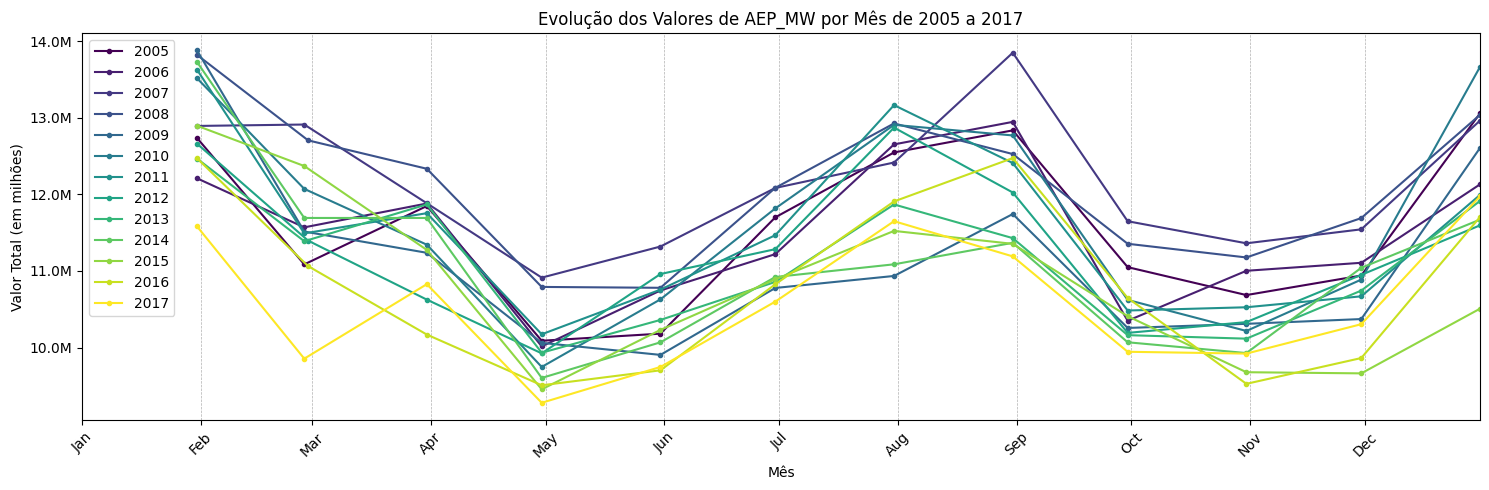

In [122]:
# Chame a função com os anos de sua escolha
plot_dados_ano(df_m, 2005, 2017)

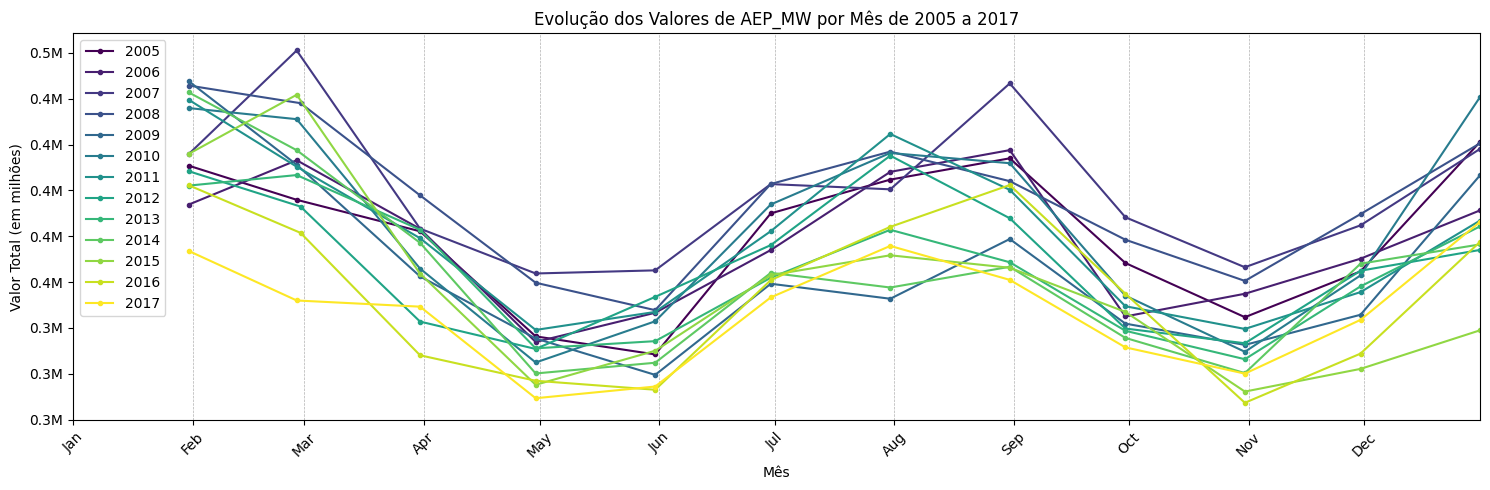

In [121]:
# Chame a função com os anos de sua escolha
plot_dados_ano(df_m2, 2005, 2017)

In [125]:
df_m3 = df.resample('D').sum().resample('W').mean()

In [126]:
df_m3.head()

,AEP_MW
Datetime,
2004-10-03,311330.333333
2004-10-10,333148.142857
2004-10-17,339740.571429
2004-10-24,339891.000000
2004-10-31,332232.000000


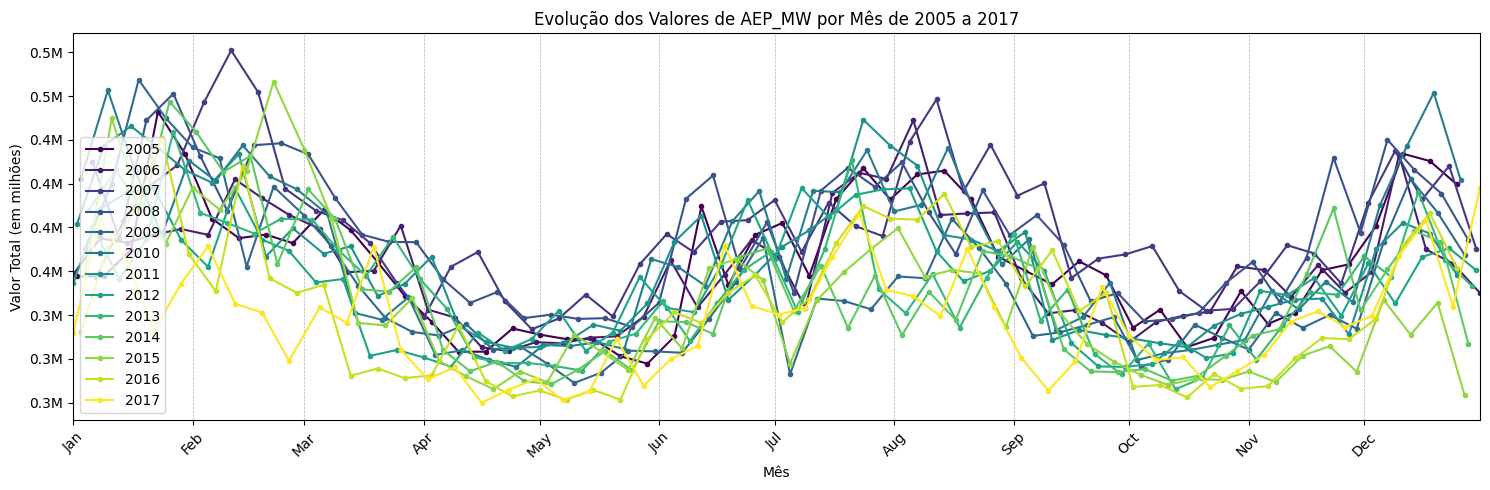

In [127]:
plot_dados_ano(df_m3, 2005, 2017)

In [133]:
df.shape[0]*0.8

97018.40000000001

In [136]:
df.iloc[97018]

AEP_MW    18343.0
Name: 2015-03-07 09:00:00, dtype: float64

In [157]:
treino = df[(df.index <= '2014-12-31')]
teste = df[(df.index >= '2015-01-01') ]

In [158]:
print(df.shape[0],'\n', treino.shape[0],'\n', teste.shape[0])

121273 
 89810 
 31440


In [159]:
intersecao_df = treino.join(teste, how='inner', lsuffix='_treino', rsuffix='_teste')

In [160]:
intersecao_df.head()

,AEP_MW_treino,AEP_MW_teste
Datetime,,


In [161]:
treino['ano'] = treino.index.year
treino['mes'] = treino.index.month
treino['dia'] = treino.index.day
treino['hora'] = treino.index.hour
#treino['minuto'] = treino.index.minute
#treino['segundo'] = treino.index.second
treino['dia_semana'] = treino.index.dayofweek  # Segunda=0, Domingo=6
treino['dia_ano'] = treino.index.dayofyear
treino['semana_ano'] = treino.index.isocalendar().week  # Número da semana no ano
treino['trimestre'] = treino.index.quarter
treino['eh_mes_inicio'] = treino.index.is_month_start  # Booleano, True se é o primeiro dia do mês
treino['eh_mes_fim'] = treino.index.is_month_end  # Booleano, True se é o último dia do mês
treino['eh_ano_inicio'] = treino.index.is_year_start  # Booleano, True se é o primeiro dia do ano
treino['eh_ano_fim'] = treino.index.is_year_end  # Booleano, True se é o último dia do ano

# Para verificar se é final de semana, podemos usar uma função lambda com dayofweek
treino['eh_final_semana'] = treino.index.dayofweek.isin([5, 6])  # Sábado=5, Domingo=6

<ipython-input-161-443dbefbdd38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['ano'] = treino.index.year
<ipython-input-161-443dbefbdd38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['mes'] = treino.index.month
<ipython-input-161-443dbefbdd38>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [162]:
treino.head()

,AEP_MW,ano,mes,dia,hora,dia_semana,dia_ano,semana_ano,trimestre,eh_mes_inicio,eh_mes_fim,eh_ano_inicio,eh_ano_fim,eh_final_semana
Datetime,,,,,,,,,,,,,,
2004-12-31 01:00:00,13478.0,2004,12,31,1,4,366,53,4,False,True,False,True,False
2004-12-31 02:00:00,12865.0,2004,12,31,2,4,366,53,4,False,True,False,True,False
2004-12-31 03:00:00,12577.0,2004,12,31,3,4,366,53,4,False,True,False,True,False
2004-12-31 04:00:00,12517.0,2004,12,31,4,4,366,53,4,False,True,False,True,False
2004-12-31 05:00:00,12670.0,2004,12,31,5,4,366,53,4,False,True,False,True,False


In [166]:
X_train = treino.drop('AEP_MW', axis=1)
y_train = treino['AEP_MW']

In [173]:
modelos = {
    'XGBoost': XGBRegressor(),
    'RandomForest': RandomForestRegressor(),
    'LightGBM': LGBMRegressor()
}

In [174]:
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=123)

resultados = {}

In [175]:
for nome, modelo in modelos.items():
    # Calculando a pontuação de validação cruzada
    # Aqui, usamos o neg_mean_squared_error como scoring para comparar baseado em RMSE
    scores = cross_val_score(modelo, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

    # Convertendo as pontuações para RMSE positivo
    rmse_scores = (-scores)**0.5

    # Armazenando a média e o desvio padrão dos RMSEs
    resultados[nome] = (rmse_scores.mean(), rmse_scores.std())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 80829, number of used features: 13
[LightGBM] [Info] Start training from score 15743.571206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 80829, number of used features: 13
[LightGBM] [Info] Start training from score 15744.727746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [176]:

# Imprimindo os resultados
for nome, (mean_rmse, std_rmse) in resultados.items():
    print(f"{nome}: RMSE médio = {mean_rmse:.3f}, Desvio padrão = {std_rmse:.3f}")

XGBoost: RMSE médio = 719.748, Desvio padrão = 11.942
RandomForest: RMSE médio = 467.536, Desvio padrão = 11.199
LightGBM: RMSE médio = 992.160, Desvio padrão = 8.621


In [178]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [179]:
# Definindo a distribuição de parâmetros para a busca aleatória
param_distributions = {
    'n_estimators': np.arange(100, 1001, 100),  # Número de árvores
    'max_features': ['auto', 'sqrt'],  # Número de características a considerar em cada divisão
    'max_depth': np.arange(10, 101, 10).tolist() + [None],  # Profundidade máxima da árvore
    'min_samples_split': np.arange(2, 11),  # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': np.arange(1, 11),  # Número mínimo de amostras necessárias em um nó folha
    'bootstrap': [True, False]  # Método de seleção de amostras para treinar cada árvore
}

In [182]:
# Configurando o RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model_rf,
                                   param_distributions=param_distributions,
                                   n_iter=80,  # Número de configurações de parâmetros a serem testadas
                                   cv=5,  # Número de folds na validação cruzada
                                   scoring='neg_mean_squared_error',  # Métrica de avaliação
                                   verbose=2,
                                   random_state=123,
                                   n_jobs=-1)  # Executar em paralelo, -1 usa todos os núcleos disponíveis


In [183]:
# Ajustando o modelo aos dados de treino
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Resultados
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (RMSE):", (-random_search.best_score_)**0.5)

In [ ]:
# Você pode usar random_search.best_estimator_ para fazer previsões
predictions = random_search.best_estimator_.predict(X_test)